# 图像增广  

### 1. 图像增广的作用  
- 图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模
- 应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。 

图像增广只在训练时随机在线进行，在测试时不进行图像增广。  

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

在对常用图像增广方法的探索时，我们将使用下面这个尺寸为400 × 500的图像作为示例。  

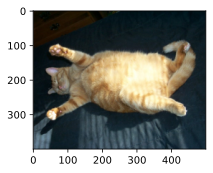

In [3]:
d2l.set_figsize()
img = d2l.Image.open('d2l_pytorch_code\pytorch\img\cat1.jpg')
d2l.plt.imshow(img)

为了便于观察图像增广的效果，我们下面定义辅助函数apply。此函数在输入图像img上多次运行图像增广方法aug并显示所有结果。

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### a. 翻转和裁剪   
我们使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转。

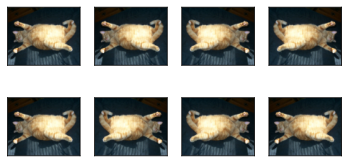

In [ ]:
# 左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

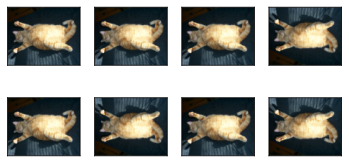

In [6]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。这也可以降低模型对目标位置的敏感性。

下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。然后，区域的宽度和高度都被缩放到200像素。

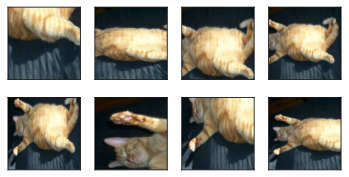

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), (0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### b. 改变颜色  

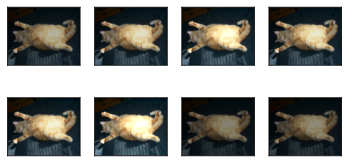

In [8]:
# 改变亮度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

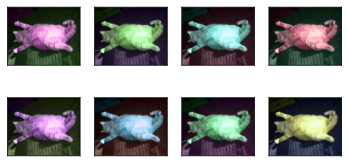

In [9]:
# 改变色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

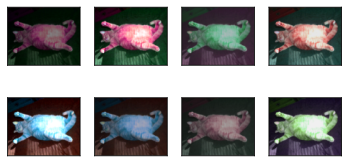

In [10]:
# 同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个Compose实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。  

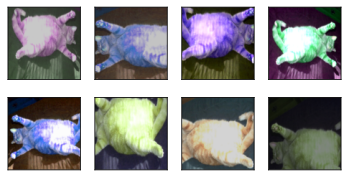

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)

### 2. 使用图像增广进行训练

CIFAR‐10数据集

100.0%


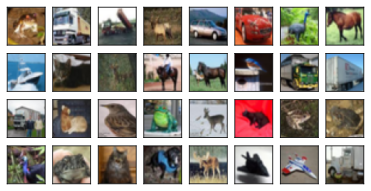

In [12]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root='data', download=True
)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

在这里，我们只使用最简单的随机左右翻转。此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。

In [13]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='data', train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                             shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

训练

In [14]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, 
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epochs', xlim=[1, num_epochs], ylim=[0, 1], 
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices
            )
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_epochs // 5) == 0 or i == num_batches - 1:
                # 在每个epoch期间，每隔5个小批量，画一个点，使曲线平滑
                animator.add(epoch + (i + 1) / num_batches, 
                (metric[0] / metric[2], metric[1] / metric[3], None)
                )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
        f'{str(devices)}')

模型，损失函数，优化函数定义

In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
def init_weight(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weight)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.224, train acc 0.923, test acc 0.818
1166.6 examples/sec on [device(type='cuda', index=0)]


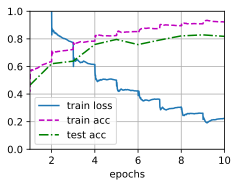

In [17]:
train_with_data_aug(train_augs, test_augs, net)